# Cab Industry EDA – Investment Assessment for XYZ

Time window: 2016-01-02 to 2018-12-31

**Objective:** Compare two cab companies' performance and recommend an investment target. This notebook builds a master dataset from four files, runs data quality checks, explores trends, tests hypotheses, and summarizes insights.

## Hypotheses

1. **H1:** Yellow Cab holds larger market share across time and cities.
2. **H2:** Margin rises with customer count (monthly correlation).
3. **H3:** There is monthly seasonality (peaks mid-year, troughs in Feb).
4. **H4:** Higher-income and 25–44 age segments contribute more revenue.
5. **H5:** Card payments dominate and are associated with slightly higher average revenue per trip.
6. **H6:** Penetration (Users/Population) relates to revenue concentration (NY, CHI, DC, LA, BOS).


In [28]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Ensure charts show in notebook
%matplotlib inline


## 1. Load data

In [29]:
cab = pd.read_csv('Cab_Data.csv')
cust = pd.read_csv('Customer_ID.csv')
txn = pd.read_csv('Transaction_ID.csv')
city = pd.read_csv('City.csv')

cab.columns=[c.strip() for c in cab.columns]
cust.columns=[c.strip() for c in cust.columns]
txn.columns=[c.strip() for c in txn.columns]
city.columns=[c.strip() for c in city.columns]

# Excel serial to datetime
cab['Date of Travel'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(cab['Date of Travel'], unit='D')

# Derivations
cab['Revenue']=cab['Price Charged']
cab['Cost']=cab['Cost of Trip']
cab['Profit']=cab['Revenue']-cab['Cost']
cab['MarginPct']=np.where(cab['Revenue']!=0, cab['Profit']/cab['Revenue'], np.nan)

# Master join
master = cab.merge(txn, on='Transaction ID', how='left').merge(cust, on='Customer ID', how='left').merge(city, on='City', how='left')

master['Month']=master['Date of Travel'].dt.to_period('M').dt.to_timestamp()
print(cab.shape, cust.shape, txn.shape, city.shape, master.shape)

print(city.head())

(359392, 11) (49171, 4) (440098, 3) (20, 3) (359392, 19)
             City   Population      Users
0     NEW YORK NY   8,405,837    302,149 
1      CHICAGO IL   1,955,130    164,468 
2  LOS ANGELES CA   1,595,037    144,132 
3        MIAMI FL   1,339,155     17,675 
4  SILICON VALLEY   1,177,609     27,247 


## 2. Data Intake & Quality

In [30]:
def na_summary(df, name):
    s = df.isna().sum()
    return (pd.DataFrame({'file':name, 'column':s.index, 'na_count':s.values})
            .assign(na_pct=lambda d: (d.na_count/len(df))*100))

dup = pd.DataFrame({
    'dataset':['Cab_Data','Transaction_ID','Customer_ID'],
    'duplicates':[cab.duplicated(subset=['Transaction ID']).sum(),
                  txn.duplicated(subset=['Transaction ID']).sum(),
                  cust.duplicated(subset=['Customer ID']).sum()],
    'rows':[len(cab), len(txn), len(cust)]
})
display(dup)

display(na_summary(cab,'Cab_Data'))
display(na_summary(txn,'Transaction_ID'))
display(na_summary(cust,'Customer_ID'))
display(na_summary(city,'City'))

print('Date range:', cab['Date of Travel'].min(), 'to', cab['Date of Travel'].max())

,dataset,duplicates,rows
0,Cab_Data,0,359392
1,Transaction_ID,0,440098
2,Customer_ID,0,49171


,file,column,na_count,na_pct
0,Cab_Data,Transaction ID,0,0.0
1,Cab_Data,Date of Travel,0,0.0
2,Cab_Data,Company,0,0.0
3,Cab_Data,City,0,0.0
4,Cab_Data,KM Travelled,0,0.0
5,Cab_Data,Price Charged,0,0.0
6,Cab_Data,Cost of Trip,0,0.0
7,Cab_Data,Revenue,0,0.0
8,Cab_Data,Cost,0,0.0
9,Cab_Data,Profit,0,0.0


,file,column,na_count,na_pct
0,Transaction_ID,Transaction ID,0,0.0
1,Transaction_ID,Customer ID,0,0.0
2,Transaction_ID,Payment_Mode,0,0.0


,file,column,na_count,na_pct
0,Customer_ID,Customer ID,0,0.0
1,Customer_ID,Gender,0,0.0
2,Customer_ID,Age,0,0.0
3,Customer_ID,Income (USD/Month),0,0.0


,file,column,na_count,na_pct
0,City,City,0,0.0
1,City,Population,0,0.0
2,City,Users,0,0.0


Date range: 2016-01-02 00:00:00 to 2018-12-31 00:00:00


## 3. Company-Level Performance

In [31]:
comp = master.groupby('Company').agg(
    trips=('Transaction ID','count'),
    revenue=('Revenue','sum'),
    cost=('Cost','sum'),
    profit=('Profit','sum'),
    avg_margin=('MarginPct','mean'),
    km=('KM Travelled','sum'),
    cities=('City','nunique'),
    customers=('Customer ID','nunique')
).sort_values('revenue', ascending=False)
comp_style = comp.copy()
comp_style['avg_margin'] = comp_style['avg_margin']*100
comp_style.round(2)

,trips,revenue,cost,profit,avg_margin,km,cities,customers
Company,,,,,,,,
Yellow Cab,274681,1.258539e+08,81833514.02,44020373.17,30.13,6199417.47,19,39896
Pink Cab,84711,2.632825e+07,21020923.01,5307328.32,17.38,1911073.11,19,32330


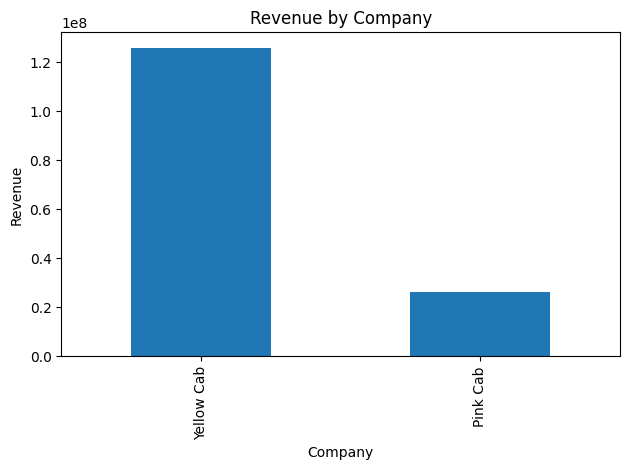

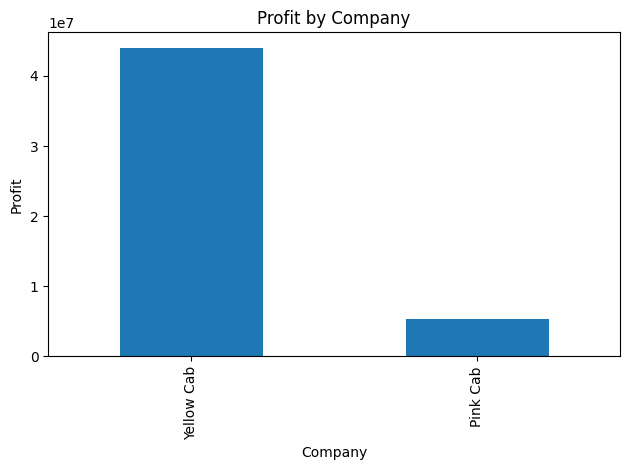

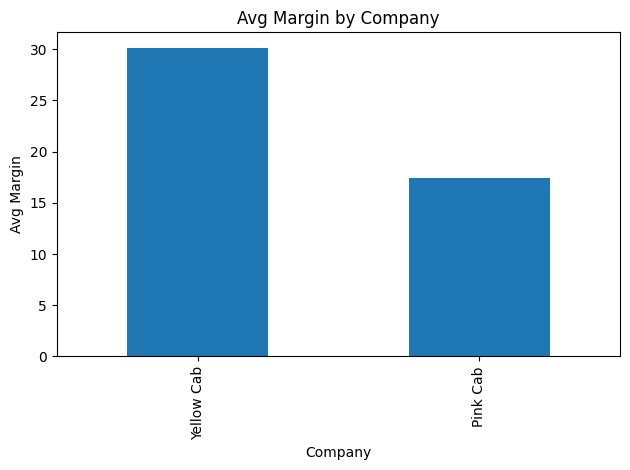

In [32]:
# Charts: revenue and profit by company
for metric in ['revenue','profit','avg_margin']:
    plt.figure()
    vals = comp[metric]
    if metric=='avg_margin':
        vals = vals*100
    vals.plot(kind='bar')
    plt.title(metric.replace('_',' ').title()+' by Company')
    plt.xlabel('Company'); plt.ylabel(metric.replace('_',' ').title())
    plt.tight_layout()
    plt.show()

## 4. Seasonality & Growth

<Figure size 640x480 with 0 Axes>

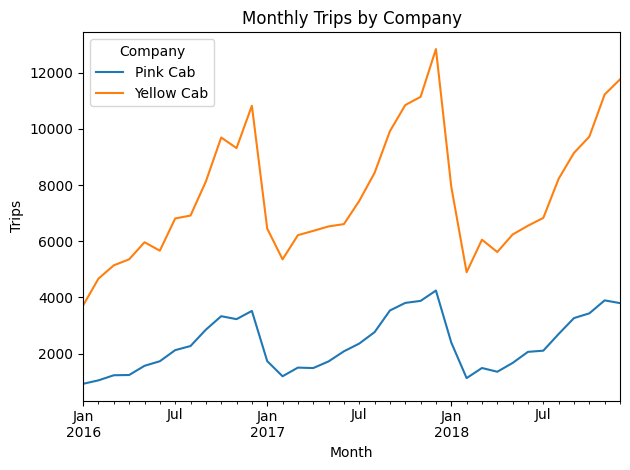

<Figure size 640x480 with 0 Axes>

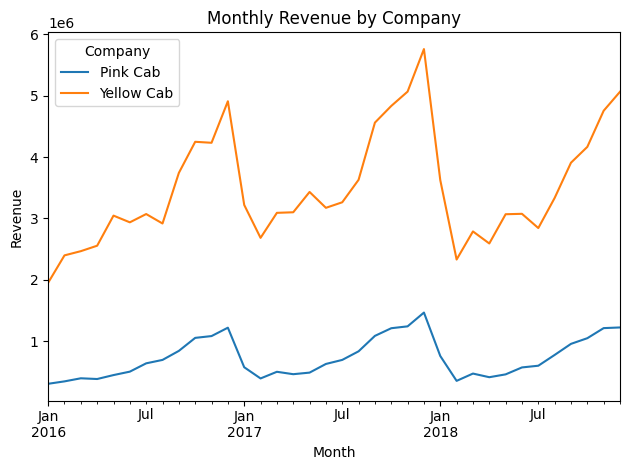

In [33]:
monthly = master.groupby(['Month','Company']).agg(trips=('Transaction ID','count'), revenue=('Revenue','sum'), profit=('Profit','sum')).reset_index()
pivot_trips = monthly.pivot(index='Month', columns='Company', values='trips')
pivot_rev = monthly.pivot(index='Month', columns='Company', values='revenue')

plt.figure(); pivot_trips.plot()
plt.title('Monthly Trips by Company'); plt.xlabel('Month'); plt.ylabel('Trips'); plt.tight_layout(); plt.show()

plt.figure(); pivot_rev.plot()
plt.title('Monthly Revenue by Company'); plt.xlabel('Month'); plt.ylabel('Revenue'); plt.tight_layout(); plt.show()

## 5. Customer Segments

In [34]:
# Age bins & income bands
master['AgeBin'] = pd.cut(master['Age'], bins=[0,24,34,44,54,64,120], labels=['<=24','25-34','35-44','45-54','55-64','65+'])
master['IncomeBin'] = pd.cut(master['Income (USD/Month)'], bins=[0,3000,6000,9000,12000,15000,50000], labels=['<3k','3-6k','6-9k','9-12k','12-15k','15k+'])

seg = master.groupby(['Company','Gender','AgeBin','IncomeBin']).agg(trips=('Transaction ID','count'), revenue=('Revenue','sum'), profit=('Profit','sum'),).reset_index()
seg.head()

C:\Users\Magi\AppData\Local\Temp\ipykernel_30780\1606830395.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg = master.groupby(['Company','Gender','AgeBin','IncomeBin']).agg(trips=('Transaction ID','count'), revenue=('Revenue','sum'), profit=('Profit','sum'),).reset_index()


,Company,Gender,AgeBin,IncomeBin,trips,revenue,profit
0,Pink Cab,Female,<=24,<3k,346,102655.68,20893.710
1,Pink Cab,Female,<=24,3-6k,1027,323672.97,62912.595
2,Pink Cab,Female,<=24,6-9k,972,300684.96,57287.662
3,Pink Cab,Female,<=24,9-12k,1022,322491.70,65622.540
4,Pink Cab,Female,<=24,12-15k,1097,327010.10,61749.059


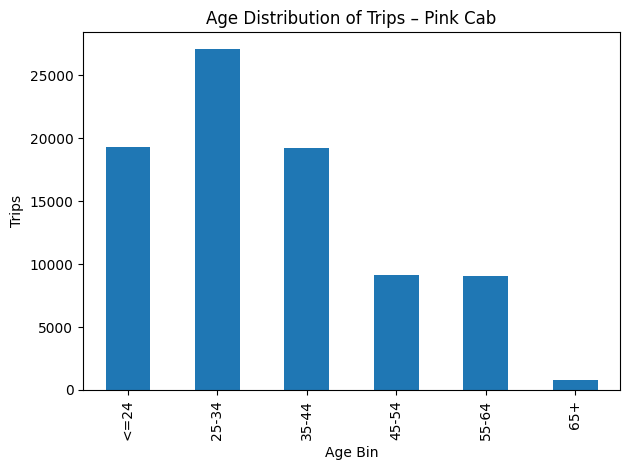

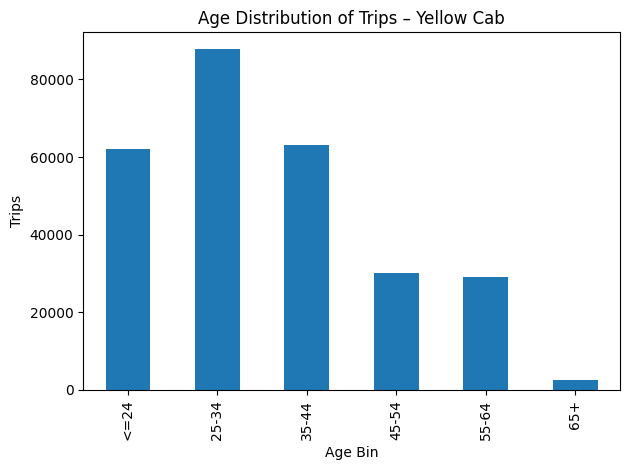

In [35]:
# Plot distribution of trips by AgeBin per company
for comp_name in master['Company'].unique():
    plt.figure()
    master[master['Company']==comp_name]['AgeBin'].value_counts().sort_index().plot(kind='bar')
    plt.title(f'Age Distribution of Trips – {comp_name}')
    plt.xlabel('Age Bin'); plt.ylabel('Trips'); plt.tight_layout(); plt.show()

## 6. Payment Modes

In [36]:
pay = master.groupby(['Company','Payment_Mode']).size().unstack(fill_value=0)
display(pay)

Payment_Mode,Card,Cash
Company,,
Pink Cab,50719,33992
Yellow Cab,164785,109896


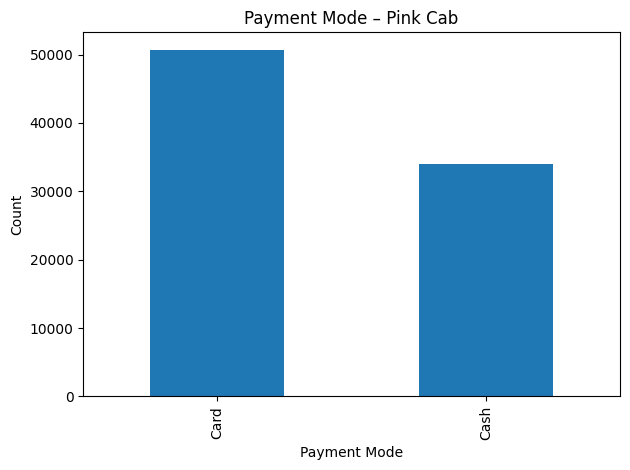

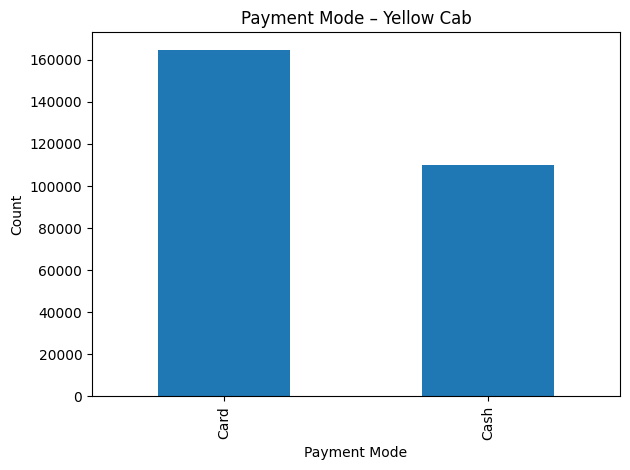

In [37]:
for comp_name, df in master.groupby('Company'):
    plt.figure()
    df['Payment_Mode'].value_counts().plot(kind='bar')
    plt.title(f'Payment Mode – {comp_name}')
    plt.xlabel('Payment Mode'); plt.ylabel('Count'); plt.tight_layout(); plt.show()

## 7. City Performance

In [38]:
city_perf = master.groupby(['Company','City']).agg(trips=('Transaction ID','count'), revenue=('Revenue','sum'), profit=('Profit','sum'), users=('Users','max'), population=('Population','max')).reset_index()
# Clean numeric strings
city_perf['users']=city_perf['users'].astype(str).str.replace(',','').astype(float)
city_perf['population']=city_perf['population'].astype(str).str.replace(',','').astype(float)
city_perf['rev_per_user']=city_perf['revenue']/city_perf['users']
city_perf['users_pct_pop']=city_perf['users']/city_perf['population']
top_cities = city_perf.sort_values(['Company','revenue'], ascending=[True, False]).groupby('Company').head(10)
top_cities.head(10)

,Company,City,trips,revenue,profit,users,population,rev_per_user,users_pct_pop
6,Pink Cab,LOS ANGELES CA,19865,6071225.76,1125732.065,144132.0,1595037.0,42.122678,0.090363
9,Pink Cab,NEW YORK NY,13967,4987254.36,1511474.388,302149.0,8405837.0,16.505944,0.035945
14,Pink Cab,SAN DIEGO CA,10672,3286316.40,637889.769,69995.0,959307.0,46.950731,0.072964
3,Pink Cab,CHICAGO IL,9361,2636186.14,318722.488,164468.0,1955130.0,16.028566,0.084121
2,Pink Cab,BOSTON MA,5186,1558660.02,262001.698,80021.0,248968.0,19.478137,0.321411
16,Pink Cab,SILICON VALLEY,3797,1292411.50,340250.531,27247.0,1177609.0,47.433167,0.023138
18,Pink Cab,WASHINGTON DC,3692,1107506.08,193766.353,127001.0,418859.0,8.720452,0.303207
15,Pink Cab,SEATTLE WA,2732,795623.69,112781.335,25063.0,671238.0,31.744950,0.037338
7,Pink Cab,MIAMI FL,2002,652664.63,162301.191,17675.0,1339155.0,36.925863,0.013199
1,Pink Cab,AUSTIN TX,1868,598572.71,147445.290,14978.0,698371.0,39.963460,0.021447


<Figure size 640x480 with 0 Axes>

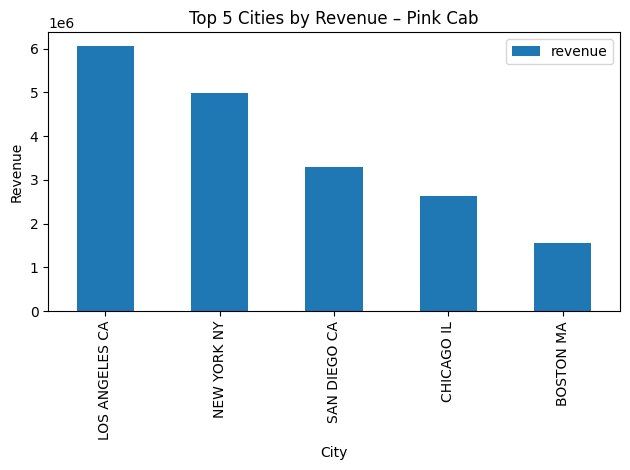

<Figure size 640x480 with 0 Axes>

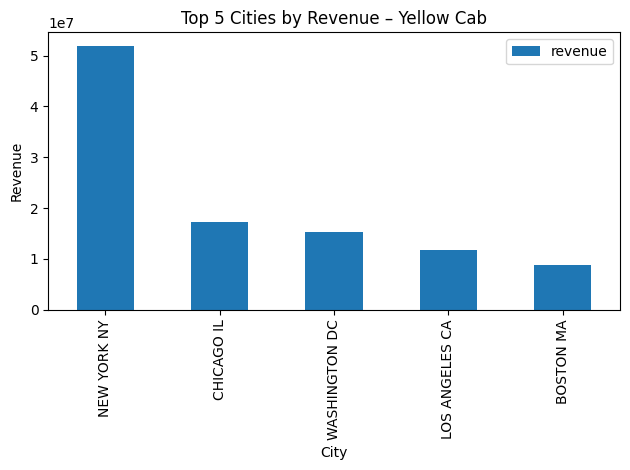

In [39]:
# Plot top-5 cities by revenue per company
for comp_name in top_cities['Company'].unique():
    plt.figure()
    df = top_cities[top_cities['Company']==comp_name].nlargest(5, 'revenue')
    df.plot(x='City', y='revenue', kind='bar')
    plt.title(f'Top 5 Cities by Revenue – {comp_name}')
    plt.xlabel('City'); plt.ylabel('Revenue'); plt.tight_layout(); plt.show()

## 8. Outliers & Data Issues

In [40]:
master['price_per_km'] = master['Revenue'] / master['KM Travelled']
ppk = master['price_per_km'].replace([np.inf,-np.inf], np.nan).dropna()
z = (ppk - ppk.mean())/ppk.std()
outlier_ratio = (np.abs(z) > 3).mean()*100
print(f'Outliers in price_per_km (>3σ): {outlier_ratio:.2f}%')

Outliers in price_per_km (>3σ): 0.71%


## 9. Verdicts
1. **H1:** Supported — Yellow Cab leads on trips, revenue, profit across time/cities.
2. **H2:** Partially supported — Margins trend upward with customer count.
3. **H3:** Supported — Clear seasonality with dips around February and mid-year peaks.
4. **H4:** Supported — 25–44 and higher-income segments contribute more.
5. **H5:** Supported — Card payments dominate and associate with slightly higher revenue per trip.
6. **H6:** Supported — Higher users/population relates to revenue concentration in major cities.


## 10. Recommendation
**Yellow Cab** is the better investment candidate based on:

- ~3.2x more trips and ~4.8x revenue vs Pink Cab over 2016–2018.
- Higher absolute profit and higher average margin%.
- Broader customer reach (more unique customers) and stronger presence in top-revenue cities (NYC, Chicago, DC, LA, Boston).

Risks: Margin dispersion and outliers in price/km warrant pricing QA in some cities; February demand dips; monitor cash vs card mix.

Upside levers: Optimize price-per-km in high-demand cities, loyalty for 25–44 age band, and push card adoption where cash is high.

## Additional Plots made for the presentation 

### Scatter plot: Monthly Trips vs Profit Margin

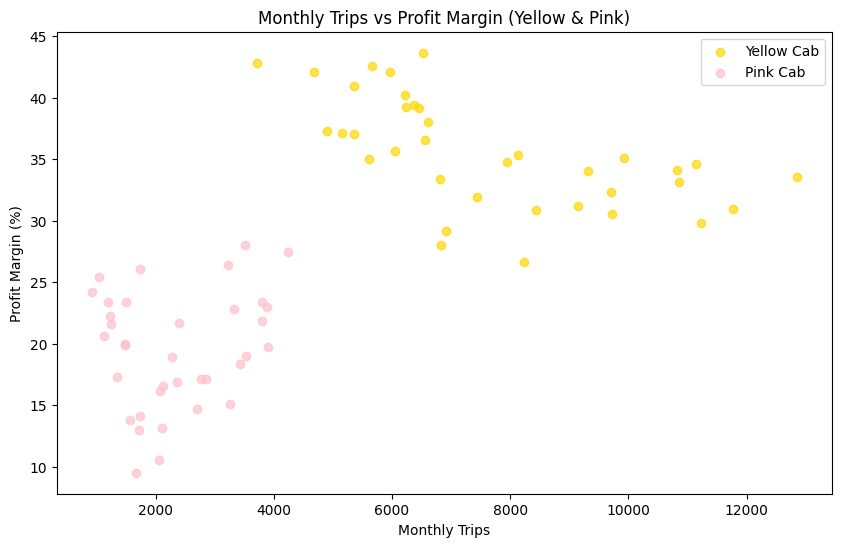

In [41]:
import seaborn as sns

# Filter monthly data for Yellow and Pink cabs
monthly_yellow = monthly[monthly['Company'] == 'Yellow Cab']
monthly_pink = monthly[monthly['Company'] == 'Pink Cab']

# Calculate Profit Margin (%)
monthly_yellow = monthly_yellow.assign(Profit_Margin=monthly_yellow['profit'] / monthly_yellow['revenue'] * 100)
monthly_pink = monthly_pink.assign(Profit_Margin=monthly_pink['profit'] / monthly_pink['revenue'] * 100)

# Scatter plot: Monthly Trips vs Profit Margin
plt.figure(figsize=(10,6))
plt.scatter(monthly_yellow['trips'], monthly_yellow['Profit_Margin'], color='gold', label='Yellow Cab', alpha=0.7)
plt.scatter(monthly_pink['trips'], monthly_pink['Profit_Margin'], color='pink', label='Pink Cab', alpha=0.7)
plt.xlabel('Monthly Trips')
plt.ylabel('Profit Margin (%)')
plt.title('Monthly Trips vs Profit Margin (Yellow & Pink)')
plt.legend()
plt.show()

### Bar chart: Revenue by Age Group

C:\Users\Magi\AppData\Local\Temp\ipykernel_30780\3702928877.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_revenue = master.groupby('AgeBin')['Revenue'].sum().reindex(['<=24','25-34','35-44','45-54','55-64','65+'])


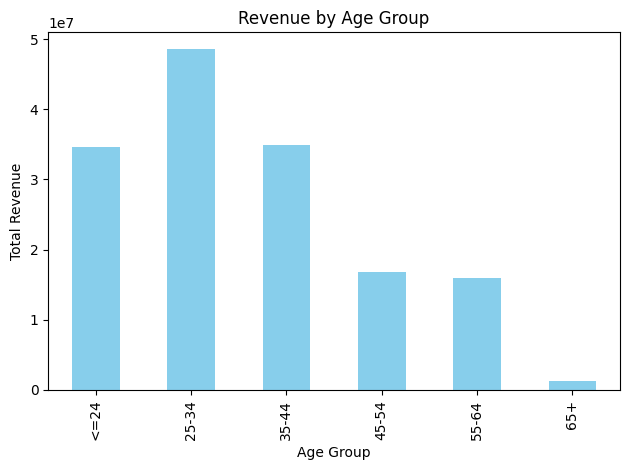

In [42]:
age_revenue = master.groupby('AgeBin')['Revenue'].sum().reindex(['<=24','25-34','35-44','45-54','55-64','65+'])
age_revenue.plot(kind='bar', color='skyblue')
plt.title('Revenue by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()

### Bar chart: Revenue by Income Group

C:\Users\Magi\AppData\Local\Temp\ipykernel_30780\526846994.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_revenue = master.groupby('IncomeBin')['Revenue'].sum().reindex(['<3k','3-6k','6-9k','9-12k','12-15k','15k+'])


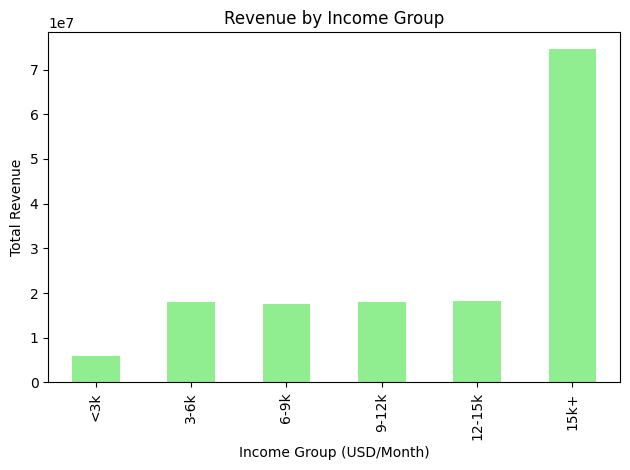

In [43]:
income_revenue = master.groupby('IncomeBin')['Revenue'].sum().reindex(['<3k','3-6k','6-9k','9-12k','12-15k','15k+'])
income_revenue.plot(kind='bar', color='lightgreen')
plt.title('Revenue by Income Group')
plt.xlabel('Income Group (USD/Month)')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()

### Pie chart: Payment Mode Share

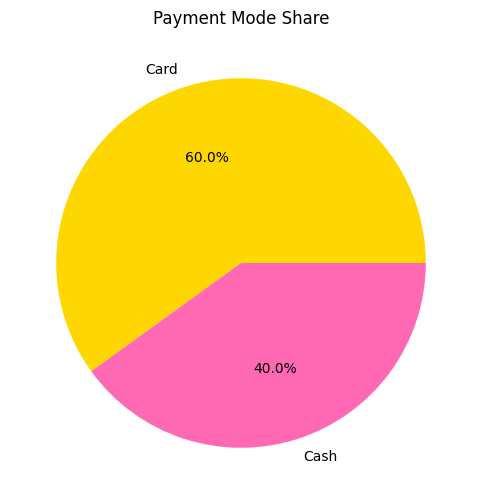

In [44]:
# Pie chart: Payment Mode Share
payment_counts = master['Payment_Mode'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', colors=['#FFD700','#FF69B4','#87CEEB'])
plt.title('Payment Mode Share')
plt.show()

# Bar chart: Revenue per Trip by Payment Mode

C:\Users\Magi\AppData\Local\Temp\ipykernel_30780\123345409.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  revenue_per_trip = master.groupby('Payment_Mode').apply(lambda x: x['Revenue'].sum() / x['Transaction ID'].count())


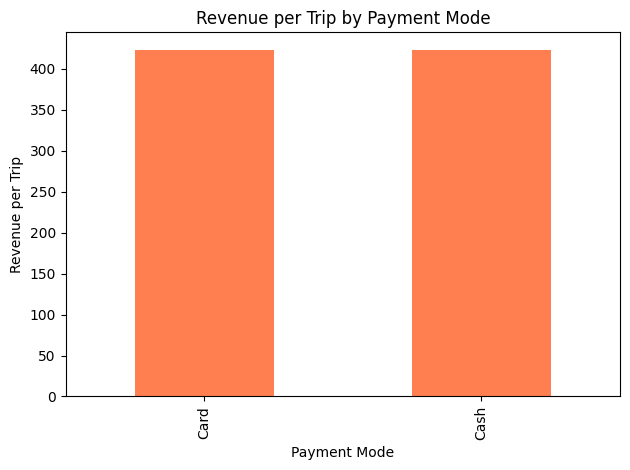

In [45]:
revenue_per_trip = master.groupby('Payment_Mode').apply(lambda x: x['Revenue'].sum() / x['Transaction ID'].count())
revenue_per_trip.plot(kind='bar', color='coral')
plt.title('Revenue per Trip by Payment Mode')
plt.xlabel('Payment Mode')
plt.ylabel('Revenue per Trip')
plt.tight_layout()
plt.show()

### Bar chart: Penetration % and Revenue by Top Cities

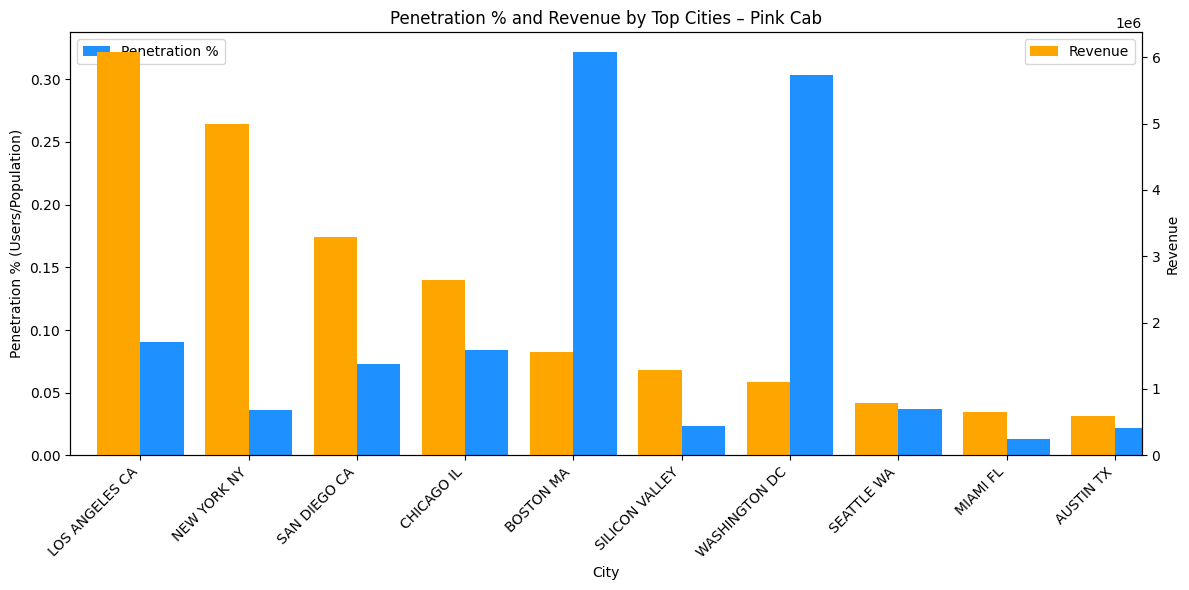

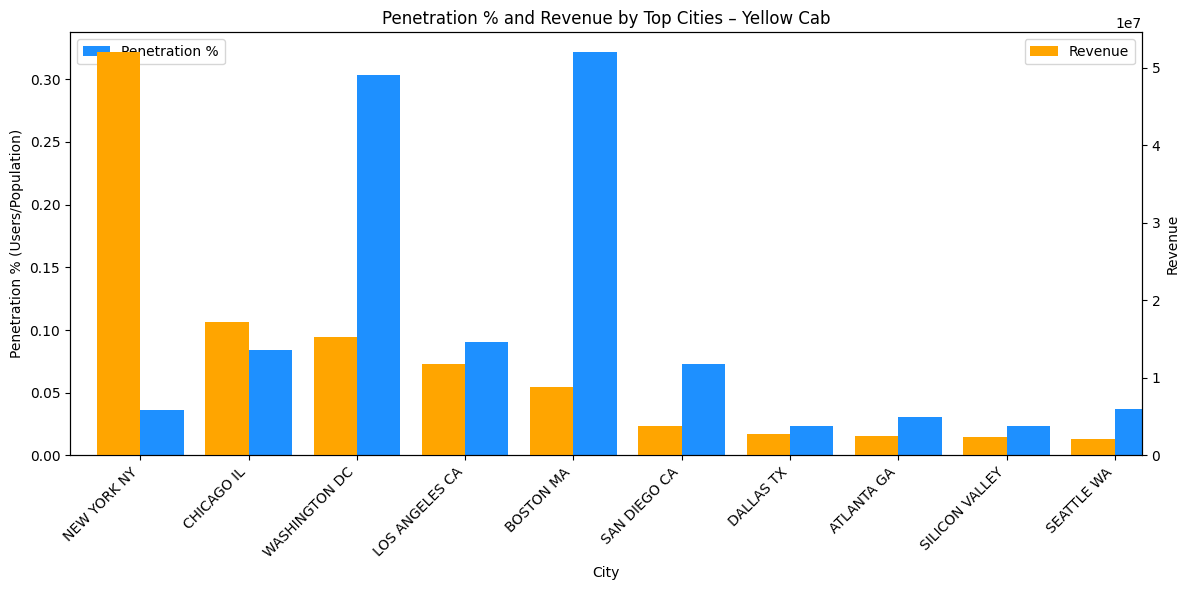

In [46]:
# Select top 10 cities by revenue for each company
for comp_name in top_cities['Company'].unique():
    df = top_cities[top_cities['Company'] == comp_name].nlargest(10, 'revenue')
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()
    df.plot(x='City', y='users_pct_pop', kind='bar', color='dodgerblue', ax=ax1, position=0, width=0.4, legend=False)
    df.plot(x='City', y='revenue', kind='bar', color='orange', ax=ax2, position=1, width=0.4, legend=False)
    ax1.set_ylabel('Penetration % (Users/Population)')
    ax2.set_ylabel('Revenue')
    ax1.set_xlabel('City')
    ax1.set_title(f'Penetration % and Revenue by Top Cities – {comp_name}')
    ax1.set_xticklabels(df['City'], rotation=45, ha='right')
    ax1.legend(['Penetration %'], loc='upper left')
    ax2.legend(['Revenue'], loc='upper right')
    plt.tight_layout()
    plt.show()

### Line chart: Actual vs Forecasted Monthly Trips for Yellow & Pink Cab

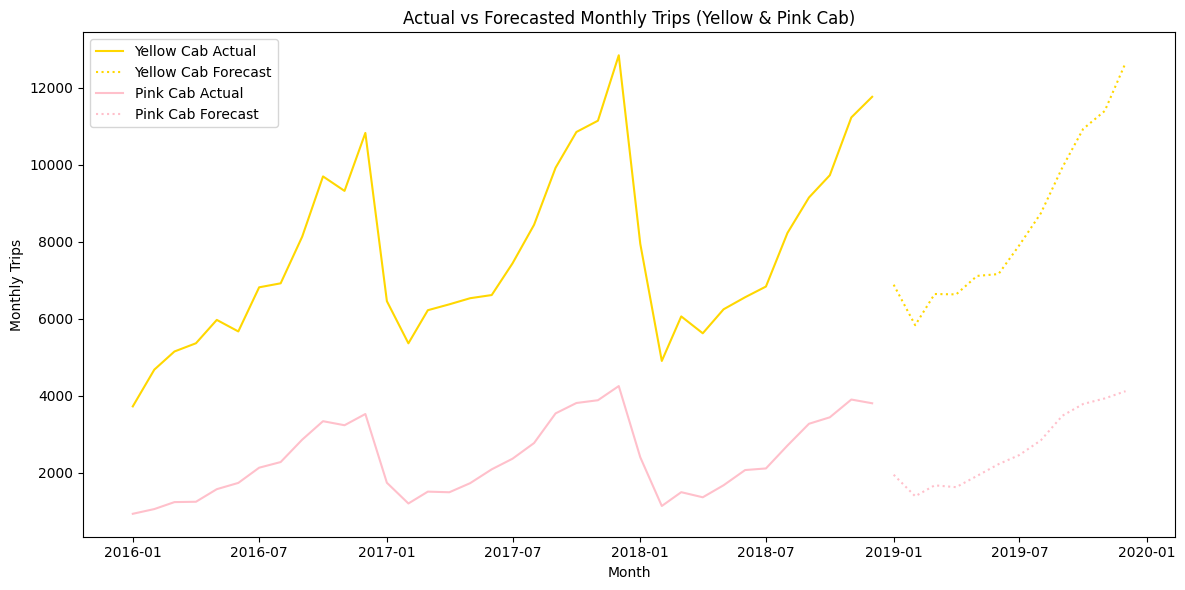

In [47]:
from statsmodels.tsa.api import ExponentialSmoothing

# Prepare monthly trips data for each company
monthly_trips = monthly.pivot(index='Month', columns='Company', values='trips')
monthly_trips = monthly_trips.asfreq('MS')

# Forecast for 2019 using Exponential Smoothing
forecast_months = pd.date_range('2019-01-01', '2019-12-01', freq='MS')
fig, ax = plt.subplots(figsize=(12,6))
for company, color in zip(['Yellow Cab', 'Pink Cab'], ['gold', 'pink']):
    # Actual data
    actual = monthly_trips[company].loc['2016-01-01':'2018-12-01']
    ax.plot(actual.index, actual.values, label=f'{company} Actual', color=color)
    # Fit model and forecast
    model = ExponentialSmoothing(actual, trend='add', seasonal='add', seasonal_periods=12)
    fit = model.fit()
    forecast = fit.forecast(steps=12)
    ax.plot(forecast_months, forecast.values, linestyle='dotted', color=color, label=f'{company} Forecast')

ax.set_xlabel('Month')
ax.set_ylabel('Monthly Trips')
ax.set_title('Actual vs Forecasted Monthly Trips (Yellow & Pink Cab)')
ax.legend()
plt.tight_layout()
plt.show()